<a href="https://colab.research.google.com/github/milver/Experiments/blob/main/Barometric_Pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Barometric Pressure Ecxtraction

In [24]:
import requests
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Function to fetch data from the API
def fetch_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to fetch data")
        return None



In [26]:
# Process the data assuming it's in Eastern Daylight Time (EDT)
def process_data(json_data, start_time, end_time):
    edt_tz = pytz.timezone('America/New_York')

    processed_data = []
    for record in json_data["historyData"]:
        edt_time = datetime.fromisoformat(record["startTime"].replace("Z", "+00:00")).astimezone(edt_tz)
        if start_time <= edt_time <= end_time:
            pressure_inhg = record["values"]["pressureSeaLevel"]
            pressure_mbar = pressure_inhg * 33.8639
            processed_data.append({
                "startTime": edt_time.strftime("%Y-%m-%dT%H:%M:%S"),
                "pressureSeaLevel_mbar": pressure_mbar
            })

    return processed_data


In [27]:
# Plotting function with migraine zone highlighting and intersection identification
def plot_data(processed_data, file_name='pressure_time_chart.png'):
    times = [datetime.fromisoformat(d['startTime']) for d in processed_data]
    pressures = [d['pressureSeaLevel_mbar'] for d in processed_data]
    rounded_times = [t.strftime('%a %-I%p') for t in times]

    plt.figure(figsize=(12, 7))
    plt.plot(rounded_times, pressures, marker='o', linestyle='-')
    plt.title('Pressure vs. Time with Migraine Zone Highlighted')
    plt.xlabel('Time')
    plt.ylabel('Pressure (mbar)')
    plt.grid(True)

    # Highlighting the migraine zone between 1003 and 1007 mbar
    plt.axhspan(1003, 1007, color='red', alpha=0.3)

    # Interpolating and identifying entry and exit times from the migraine zone
    pressures_np = np.array(pressures)
    times_np = np.array(times)
    for threshold in [1003, 1007]:
        idx_below = np.where(pressures_np < threshold)[0]
        idx_above = np.where(pressures_np > threshold)[0]
        if idx_below.size > 0 and idx_above.size > 0:
            idx_near_below = idx_below[np.argmax(idx_below < idx_above[0])]
            idx_near_above = idx_above[np.argmin(idx_above > idx_near_below)]
            time_below = times_np[idx_near_below]
            time_above = times_np[idx_near_above]
            pressure_below = pressures_np[idx_near_below]
            pressure_above = pressures_np[idx_near_above]

            # Calculate the interpolated time
            delta_t = (threshold - pressure_below) / (pressure_above - pressure_below)
            interpolated_time = time_below + (time_above - time_below) * delta_t
            rounded_time = interpolated_time.strftime('%a %-I%p')
            plt.axvline(x=rounded_time, color='blue', linestyle='--')
            plt.text(rounded_time, threshold, f'{rounded_time}', fontsize=9, ha='right')

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig(file_name)
    plt.show()

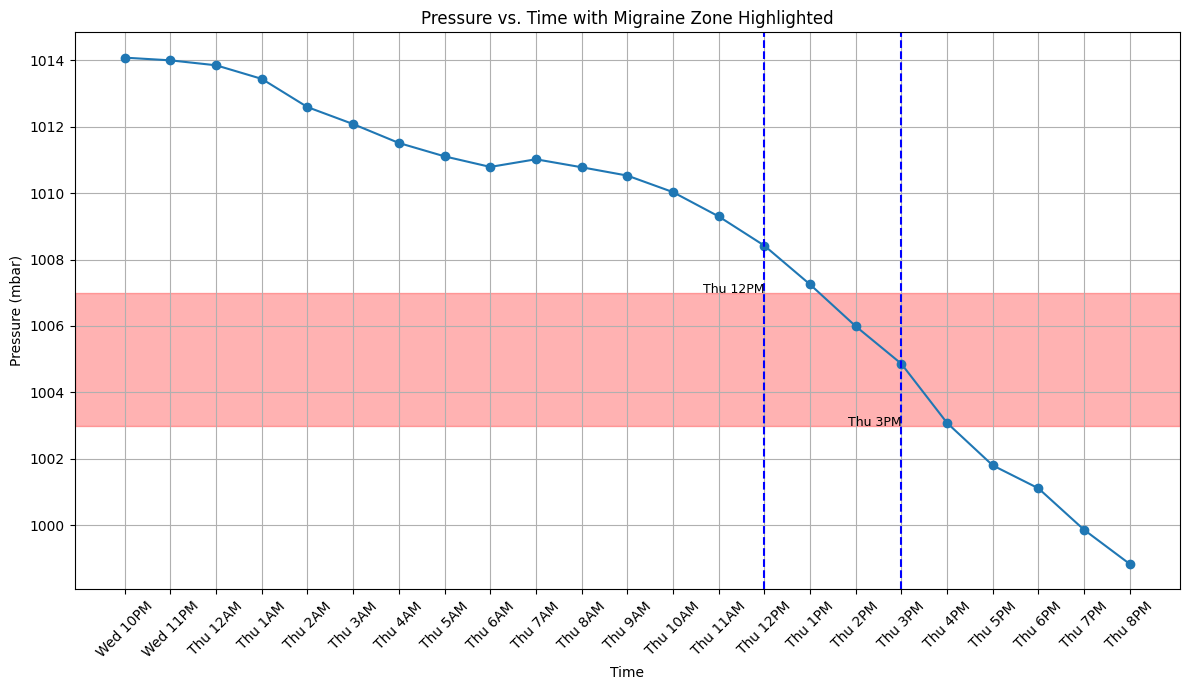

In [28]:
# URL to fetch data from
url = 'https://barometricpressure.app/api/timelineWk?lat=39.020834&lng=-77.50411'

# Fetch and process the data
json_data = fetch_data(url)
if json_data:
    edt_tz = pytz.timezone('America/New_York')
    current_time = datetime.now(edt_tz)
    start_time_input = current_time - timedelta(hours=24)
    end_time_input = current_time
    processed_data = process_data(json_data, start_time_input, end_time_input)
    plot_data(processed_data, 'pressure_time_chart.png')